# try to get tutorial way to work

In [1]:
import pyro

In [2]:
import os
from collections import defaultdict
import numpy as np
import scipy.stats
import torch
from torch.distributions import constraints
import pyro.distributions as dist
from pyro import poutine
from pyro.contrib.autoguide import AutoDelta
from pyro.optim import Adam
from pyro.infer import SVI, TraceEnum_ELBO, config_enumerate, infer_discrete
from matplotlib import pyplot as plt
%matplotlib inline
pyro.enable_validation(True)

In [25]:
data = torch.tensor([0., 1., 0.5, 10., 11., 12., 11.3, 11.4])

In [26]:
K = 2

In [27]:
@config_enumerate
def model(data):
    weights = pyro.sample('weights', dist.Dirichlet(torch.ones(K)/K))
    scale = pyro.sample('scale', dist.LogNormal(0., 2.))
    with pyro.plate('components', K):
        locs = pyro.sample('locs', dist.Normal(0., 10.))
    with pyro.plate('data', len(data)):
        assignment = pyro.sample('assignment', dist.Categorical(weights))
        pyro.sample('obs', dist.Normal(locs[assignment], scale), obs=data)

In [28]:
global_guide = AutoDelta(poutine.block(model, expose=['weights', 'locs', 'scale']))
# tutorial uses lr='0.01', betas=[0.8, 0.99]
optim = Adam({'lr': 0.01, 'betas': [0.8, 0.99]})

In [29]:
elbo = TraceEnum_ELBO(max_plate_nesting=1)
svi = SVI(model, global_guide, optim, loss=elbo)

In [46]:
def initialize(seed):
    pyro.set_rng_seed(seed)
    pyro.clear_param_store()
    pyro.param('auto_weights', 0.5 * torch.ones(K), constraint=constraints.simplex)
    pyro.param("auto_scale", (data.var()/2).sqrt(), constraint=constraints.positive)
    # randomly choose K data points as starting locations
    idxs = torch.multinomial(torch.ones(len(data))/len(data), K)
    pyro.param('auto_locs', data[idxs])
    loss = svi.loss(model, global_guide, data)
    return loss

In [47]:
loss, seed = min((initialize(seed), seed) for seed in range(100))
initialize(seed)
print("seed = {}, initial_loss = {}".format(seed, loss))

seed = 0, initial_loss = 155.3062286376953


In [48]:
gradient_norms = defaultdict(list)
for name, value in pyro.get_param_store().named_parameters():
    value.register_hook(lambda g, name=name: gradient_norms[name].append(g.norm().item()))
losses = []
for i in range(200):
    loss = svi.step(data)
    losses.append(loss)
    print('.' if i%100 else '\n', end='')


...................................................................................................
...................................................................................................

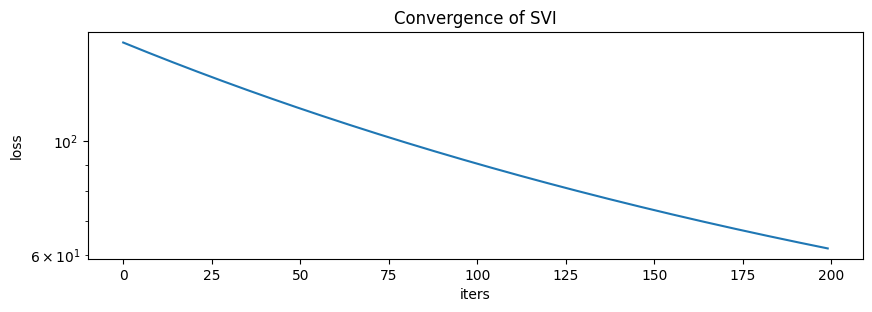

In [49]:
plt.figure(figsize=(10,3), dpi=100).set_facecolor('white')
plt.plot(losses)
plt.xlabel('iters')
plt.ylabel('loss')
plt.yscale('log')
plt.title('Convergence of SVI');

In [50]:
map_estimates = global_guide(data)
weights = map_estimates['weights']
locs = map_estimates['locs']
scale = map_estimates['scale']
print('weights = {}'.format(weights.data.numpy()))
print('locs = {}'.format(locs.data.numpy()))
print('scale = {}'.format(scale.data.numpy()))



weights = [0.00653895 0.993461  ]
locs = [0.20157723 1.7506026 ]
scale = 2.3763985633850098


Text(0, 0.5, 'probability density')

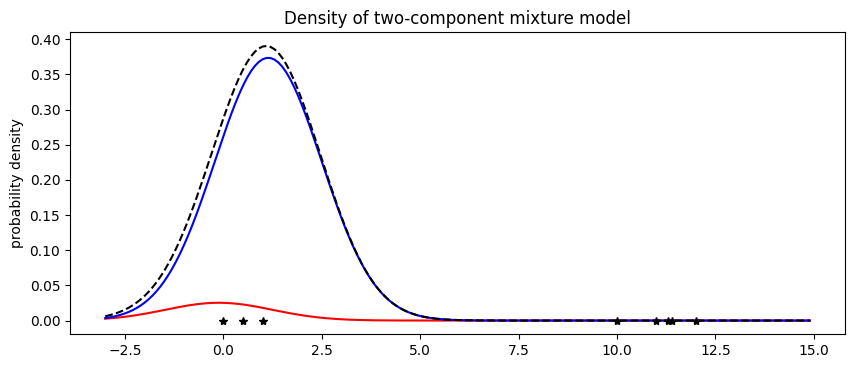

In [35]:


X = np.arange(-3,15,0.1)
Y1 = weights[0].item() * scipy.stats.norm.pdf((X - locs[0].item()) / scale.item())
Y2 = weights[1].item() * scipy.stats.norm.pdf((X - locs[1].item()) / scale.item())

plt.figure(figsize=(10, 4), dpi=100).set_facecolor('white')
plt.plot(X, Y1, 'r-')
plt.plot(X, Y2, 'b-')
plt.plot(X, Y1 + Y2, 'k--')
plt.plot(data.data.numpy(), np.zeros(len(data)), 'k*')
plt.title('Density of two-component mixture model')
plt.ylabel('probability density')

